# Green tea compounds in plasma

- using a QIIME2 2021.11 conda environment

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qiime2 import Artifact, Visualization

from skbio.diversity import beta_diversity, alpha_diversity
from skbio.diversity.beta import unweighted_unifrac
from skbio.stats import distance, ordination
from skbio import DistanceMatrix

from sklearn.decomposition import PCA

from scipy.spatial import procrustes

%matplotlib inline

## Read in data

### Metadata

In [2]:
metadata = pd.read_csv("../metadata/mapping.tsv", sep="\t")
metadata.head()

,#SampleID,MetaboSampleID,Plate,Well,#,BarcodeSequence,LinkerPrimerSequence,BarcodeName,PID,Group,Study,DNA_Conc,Amplified_Conc,Extraction_Date,Extraction_Location,Extraction_By
0,GT.063_N,18,2,B07,48,TTAACAAGGCAA,GTGYCAGCMGCCGCGGTAA,515rcbc222,63,Red,Green Tea,15.3,62.55,10/13/21,BSC,MK
1,GT.063_R,3,1,E01,49,TGATGTGCTAAG,GTGYCAGCMGCCGCGGTAA,515rcbc48,63,Red,Green Tea,39.9,51.15,10/13/21,BSC,MK
2,GT.066_B,17,2,A09,54,CCAGGACAGGAA,GTGYCAGCMGCCGCGGTAA,515rcbc200,66,Red,Green Tea,18.6,67.90,10/13/21,BSC,MK
3,GT.066_N,29,1,F12,55,AACTCAATAGCG,GTGYCAGCMGCCGCGGTAA,515rcbc167,66,Red,Green Tea,32.9,41.80,10/13/21,BSC,MK
4,GT.074_N,2,2,C12,52,GATATACCAGTG,GTGYCAGCMGCCGCGGTAA,515rcbc227,74,Red,Green Tea,9.8,38.75,10/13/21,BSC,MK


In [3]:
metabo_metadata = metadata.set_index("MetaboSampleID")

### Aqueous metabolome fraction

In [4]:
aqueous = pd.read_csv("../metabolome/Aqueous_Green_Tea_compounds_in_Plasma_020722.txt",
                      sep="\t", header=11, index_col="Compound").T
aqueous.head()

Compound,L-ISOLEUCINE**_1.428,Adenosine_4.092,Rehmaionoside C_7.64,Phenyl pyruvic acid_1.827,Pipecolic acid_2.82,C11 - 0.839,C13 - 1.093,C15 - 0.838,Piperidine_1.424,L-leucyl-L-proline_2.533,...,C2252 - 0.847,Valyl-Tyrosine_6.482,C2327 - 6.957,C2340 - 0.797,C2409 - 8.239,Tryptophyl-Leucine_7.759,Taraxinic acid 1'-O-beta-D-glucopyranoside_6.684,Lactiflorin_7.997,C2556 - 6.454,Leucyl-phenylalanine_7.238
report.results_GT_001_SBAQ_1(raw),17712000.0,146348.17,6398.4355,10674177.0,5768.1445,12170999.0,88575.1,9003215.0,61180444.0,657187.5,...,16241.985,14520.984,7045.5303,48157.723,0.00001,13797.909,0.00001,0.00001,27817.25,0.00001
report.results_GT_001_SBAQ_10(raw),17035938.0,607119.7,1455.5625,5485058.0,0.00001,12346700.0,116277.28,9638772.0,57270492.0,838093.0,...,19492.068,8145.5244,15454.732,56170.39,6789.9565,30013.299,0.00001,12012.743,140034.2,2327.0073
report.results_GT_001_SBAQ_11(raw),20275532.0,1020185.25,3444.505,39494272.0,13877.56,14251298.0,67781.93,10477635.0,48008460.0,1061066.8,...,23296.305,1707.6627,14735.302,68097.46,0.00001,30760.3,6226.627,2626.8083,144762.81,2836.1697
report.results_GT_001_SBAQ_12(raw),15365725.0,1551649.2,0.00001,40230988.0,0.00001,11668012.0,62352.82,8724246.0,61709096.0,1035873.1,...,15679.882,1070.6887,15523.82,30887.729,616.637,26817.178,3865.2488,13227.847,129917.61,1829.9155
report.results_GT_001_SBAQ_13(raw),13433810.0,407411.6,29579.545,40273104.0,10662.446,13293888.0,43721.836,9790668.0,32929592.0,1351724.8,...,17213.516,4386.807,31494.248,93080.14,0.00001,14800.214,23253.973,0.00001,42364.594,22198.748


In [5]:
raw_indexes =        [x for x in list(aqueous.index) if ("Log2(normalized)" not in x)]
normalized_indexes = [x for x in list(aqueous.index) if ("(raw)" not in x)]

raw_aqueous = aqueous.loc[raw_indexes]
log_aqueous = aqueous.loc[normalized_indexes]

In [6]:
raw_aqueous.index = [int(x.split("SBAQ_")[-1][:-5]) if ("SBAQ_" in x)
                     else x 
                     for x in list(raw_aqueous.index)]

log_aqueous.index = [int(x.split("SBAQ_")[-1][:-18]) if ("SBAQ_" in x)
                     else x 
                     for x in list(log_aqueous.index)]

### Metabolome lipid fraction

In [7]:
lipid = pd.read_csv("../metabolome/Lipid_Green_Tea_compounds_in_Plasma_020722.txt",
                      sep="\t", header=11, index_col="Compound").T
lipid.head()

Compound,"MGDG(20:5(5Z,8Z,11Z,14Z,17Z)/18:4(6Z,9Z,12Z,15Z))_4.412","MGDG(18:3(9Z,12Z,15Z)/18:3(9Z,12Z,15Z))_5.129","PC(14:0/20:3(5Z,8Z,11Z))_4.716","PC(22:5(7Z,10Z,13Z,16Z,19Z)/14:0)_4.33",METHYL BETA-D-GALACTOSIDE**_0.414,"PA(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/22:2(13Z,16Z))_5.211","MGDG(20:5(5Z,8Z,11Z,14Z,17Z)/18:4(6Z,9Z,12Z,15Z))_4.32",C24 - 2.571,C26 - 3.214,"MGDG(18:2(9Z,12Z)/18:3(9Z,12Z,15Z))_5.533",...,C1767 - 1.635,Mannosyl-1beta-phosphomycoketide C32_6.516,C1772 - 2.203,C1775 - 6.974,Enalkiren_3.446,C1788 - 2.23,"PA(22:4(7Z,10Z,13Z,16Z)/21:0)_7.796",C1791 - 6.911,PG(17:1(9Z)/12:0)_3.854,C1802 - 1.092
report.results_GT_001_Lipid_1(raw),123458.85,6465828.0,11755339.0,1834489.8,122245.766,103096.06,126109.484,70565.21,98298.47,701912.44,...,77175.2,86081.266,21798.504,144493.11,35579.188,64894.977,12877.633,25663.674,40787.43,96877.79
report.results_GT_001_Lipid_10(raw),57086.8,8076250.0,2574086.8,1366190.9,91752.41,455115.38,55665.836,17106.846,37209.902,871031.7,...,75847.195,192845.1,32461.479,50819.875,55295.19,45620.074,41866.945,18297.928,22361.209,591896.94
report.results_GT_001_Lipid_11(raw),75968.305,6232196.5,3228597.5,1775793.1,164705.14,304191.0,79968.3,5382.238,3980.5962,679151.75,...,73047.81,95249.44,23539.396,73425.69,61335.047,68689.91,45314.484,107591.984,32179.262,525234.0
report.results_GT_001_Lipid_12(raw),40424.945,8737200.0,11179583.0,2147404.2,113370.95,469620.56,39896.1,5930.5845,23645.172,919269.9,...,76264.88,1981478.4,53140.465,8387.661,47049.875,40646.242,44129.113,46670.71,40993.27,975717.0
report.results_GT_001_Lipid_13(raw),78125.07,6155770.5,6947831.5,1633273.5,89395.72,369602.88,81217.79,19604.162,33629.78,657940.25,...,86367.96,133077.25,22941.072,57134.555,29504.742,48089.707,19964.426,20215.764,35330.617,35483.203


In [8]:
raw_lipid_indexes =        [x for x in list(lipid.index) if ("Log2(normalized)" not in x)]
normalized_lipid_indexes = [x for x in list(lipid.index) if ("(raw)" not in x)]

raw_lipid = lipid.loc[raw_lipid_indexes]
log_lipid = lipid.loc[normalized_lipid_indexes]

In [9]:
raw_lipid.index = [int(x.split("Lipid_")[-1][:-5]) if ("Lipid_" in x)
                     else x 
                     for x in list(raw_lipid.index)]

log_lipid.index = [int(x.split("Lipid_")[-1][:-18]) if ("Lipid" in x)
                     else x 
                     for x in list(log_lipid.index)]

In [10]:
metabo_info_cols = ['Compound Name','Retention Time', 'Measured Retention Time', 
                    'Product Mass','QualifierMass', 'CASNumber', 
                    'CompoundType', 'ISTDCompoundName', 'Mass Column']

### Microbiome

In [11]:
microbiome = Artifact.load("../microbiome/tax_filtered_GT.qza").view(pd.DataFrame)

In [12]:
tax = Artifact.load("../microbiome/taxonomy_GT.qza").view(pd.DataFrame)
tax = tax.to_dict()["Taxon"]
microbiome.rename(columns=tax, inplace=True) # map OTUs to taxonomy name

In [13]:
microbiome_mat = np.matrix(microbiome)
microbiome_mat /= microbiome_mat.sum(axis=1) #convert to relative abundances

microbiome = pd.DataFrame(microbiome_mat, columns=microbiome.columns, index=microbiome.index)

In [14]:
microbiome_index_mapper = metadata.set_index("#SampleID")["MetaboSampleID"].to_dict()

new_microbiome_index = [int(microbiome_index_mapper[x]) for x in list(microbiome.index)]
microbiome.index = new_microbiome_index
microbiome = microbiome.sort_index()

## Analysis

### Metabolome beta diversity

### PCA

In [15]:
aqueous_pca = PCA(n_components=3)
aqueous_pca_res = aqueous_pca.fit_transform(raw_aqueous.drop(metabo_info_cols, 
                                                             axis=0).reindex(metabo_metadata.index))

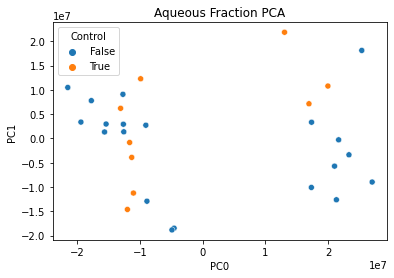

In [145]:
ax = sns.scatterplot(x=aqueous_pca_res[:,0], y=aqueous_pca_res[:,1],
                     hue=metabo_metadata["PID"]=="Control")
ax.set(xlabel="PC0", ylabel="PC1", title="Aqueous Fraction PCA")
plt.legend(title="Control")

#for i, name in enumerate(metabo_metadata.index):
#    ax.text(x=aqueous_pca_res[i,0],
#            y=aqueous_pca_res[i,1],
#            s=name)

**To see if 12, 25, and 21** look a certain way with the microbiome...

In [17]:
Visualization.load("../microbiome/core-metrics/taxa-bar-GT.qzv")

<visualization: Visualization uuid: f572ae2a-0689-481d-aa0c-ae38dada7250>

In [18]:
metabo_metadata.loc[[12,25,21]]

,#SampleID,Plate,Well,#,BarcodeSequence,LinkerPrimerSequence,BarcodeName,PID,Group,Study,DNA_Conc,Amplified_Conc,Extraction_Date,Extraction_Location,Extraction_By
MetaboSampleID,,,,,,,,,,,,,,,
12,GT.GFR_CO,2,C06,59,TGGTGGAGTTTC,GTGYCAGCMGCCGCGGTAA,515rcbc221,Control,Orange,Green Tea,12.3,54.7,10/13/21,BSC,MK
25,GT.GFB_C.R,2,F03,47,CACCCTTGCGAC,GTGYCAGCMGCCGCGGTAA,515rcbc254,Control,Red,Green Tea,6.0,76.0,10/13/21,BSC,MK
21,GT.GFL_CO,2,F06,60,TCGCTACAGATG,GTGYCAGCMGCCGCGGTAA,515rcbc257,Control,Orange,Green Tea,3.0,48.1,10/13/21,BSC,MK


**Doesn't look like they're the "different" controls**

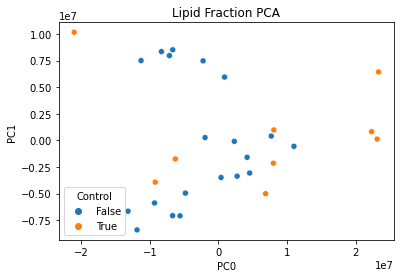

In [19]:
lipid_pca = PCA(n_components=3)
lipid_pca_res = lipid_pca.fit_transform(raw_lipid.drop(metabo_info_cols, 
                                                             axis=0).reindex(metabo_metadata.index))

ax = sns.scatterplot(x=lipid_pca_res[:,0], y=lipid_pca_res[:,1],
                     hue=metabo_metadata["PID"]=="Control")
ax.set(xlabel="PC0", ylabel="PC1", title="Lipid Fraction PCA")
plt.legend(title="Control")

### PCoA with Bray Curtis

In [20]:
aqueous_bray = beta_diversity(metric="braycurtis",
                              counts=raw_aqueous.drop(metabo_info_cols, axis=0).reindex(metabo_metadata.index), 
                              ids=metabo_metadata.index)

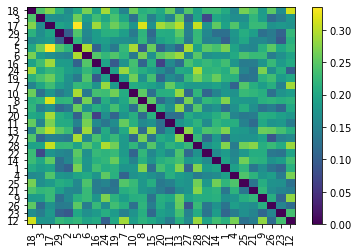

In [21]:
aqueous_bray

/Users/johnsterrett/mambaforge/envs/qiime2-2021.11/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.02221753578741084 and the largest is 0.20095390757708628.
  warn(


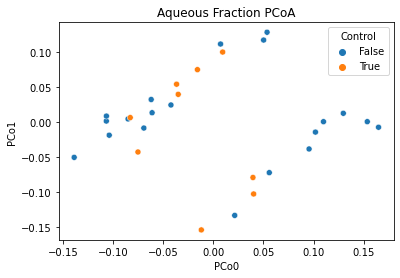

In [22]:
aqueous_pcoa_res = ordination.pcoa(aqueous_bray, number_of_dimensions=3)
ax = sns.scatterplot(x=aqueous_pcoa_res.samples["PC1"],
                     y=aqueous_pcoa_res.samples["PC2"],
                     hue=metabo_metadata["PID"]=="Control")
ax.set(xlabel="PCo0", ylabel="PCo1", title="Aqueous Fraction PCoA")
plt.legend(title="Control")

/Users/johnsterrett/mambaforge/envs/qiime2-2021.11/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.004372512892858705 and the largest is 0.24897841277437294.
  warn(


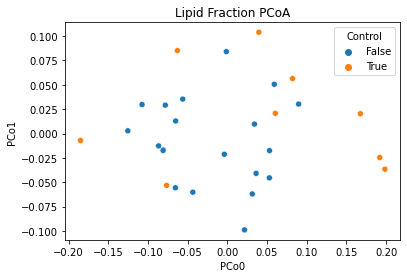

In [23]:
lipid_bray = beta_diversity(metric="braycurtis",
                              counts=raw_lipid.drop(metabo_info_cols, axis=0).reindex(metabo_metadata.index), 
                              ids=metabo_metadata.index)

lipid_pcoa_res = ordination.pcoa(lipid_bray, number_of_dimensions=3)
ax = sns.scatterplot(x=lipid_pcoa_res.samples["PC1"],
                     y=lipid_pcoa_res.samples["PC2"],
                     hue=metabo_metadata["PID"]=="Control")
ax.set(xlabel="PCo0", ylabel="PCo1", title="Lipid Fraction PCoA")
plt.legend(title="Control")

## Microbiome PCoA

In [152]:
microbiome_pcoa_u_uni = ordination.pcoa(microbiome_u_uni, number_of_dimensions=3)

/Users/johnsterrett/mambaforge/envs/qiime2-2021.11/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.009383724064282492 and the largest is 2.384134278128227.
  warn(


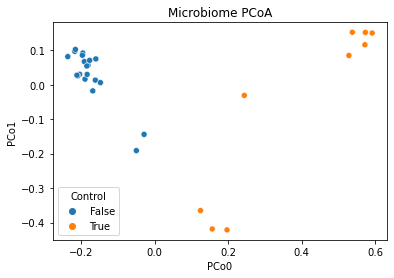

In [158]:
ax = sns.scatterplot(x=microbiome_pcoa_u_uni.samples["PC1"],
                     y=microbiome_pcoa_u_uni.samples["PC2"],
                     hue=metabo_metadata["PID"]=="Control")
ax.set(xlabel="PCo0", ylabel="PCo1", title="Microbiome PCoA")
plt.legend(title="Control")
plt.show()

In [154]:
sns.microbiome_pcoa_u_uni.samples

,PC1,PC2,PC3
18,-0.169090,-0.017804,0.080981
3,-0.204860,0.030527,0.040824
17,-0.209810,0.025906,0.076531
29,-0.212306,0.027731,0.079531
2,-0.029407,-0.144087,-0.412785
5,-0.050522,-0.191161,-0.331007
6,-0.218034,0.096913,-0.026699
16,-0.196220,0.092263,-0.021942
24,-0.237139,0.081725,0.040224
19,-0.190267,0.016270,0.078006


## What compounds are associated with microbiome composition?

In [24]:
raw_aqueous_samples = raw_aqueous.drop(metabo_info_cols).sort_index()
raw_lipid_samples = raw_lipid.drop(metabo_info_cols).sort_index()

In [25]:
microbiome_u_uni = Artifact.load("../microbiome/core-metrics/unweighted_unifrac_distance_matrix.qza").view(DistanceMatrix)

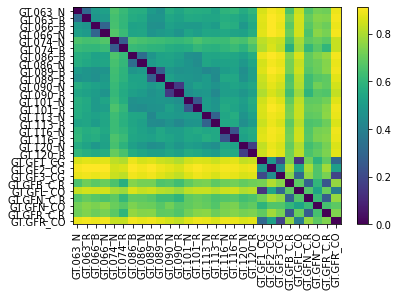

In [26]:
microbiome_u_uni

In [27]:
microbiome_u_uni_df = microbiome_u_uni.to_data_frame()

new_microbiome_u_uni_index = [int(microbiome_index_mapper[x]) for x in list(microbiome_u_uni_df.index)]
microbiome_u_uni_df.index = new_microbiome_u_uni_index
microbiome_u_uni_df = microbiome_u_uni_df.rename(index=microbiome_index_mapper, 
                                                 columns=microbiome_index_mapper)
microbiome_u_uni = DistanceMatrix(microbiome_u_uni_df, ids=microbiome_u_uni_df.index)

In [28]:
def make_euclidean_distance_matrix(data, ids):
    data = np.array(data)
    
    matrix_shape = (data.shape[0], data.shape[0])
    out_matrix = np.empty(matrix_shape)
    
    for i, entry in enumerate(data):
        for j, entry_2 in enumerate(data):
            if i==j:
                out_matrix[i,i] = 0
            elif i<j:
                diff = np.abs(entry_2 - entry)
                out_matrix[i,j] = diff
                out_matrix[j,i] = diff
                
            else:
                pass
    
    return DistanceMatrix(out_matrix, ids=ids)

### Aqueous

In [71]:
raw_aqueous_samples_index = raw_aqueous_samples.index
raw_aqueous_mantel_results_u = pd.DataFrame(index=raw_aqueous_samples.columns,
                                            columns=["corr","p"])

for col in raw_aqueous_samples.columns:
    metabo_dist_mat = make_euclidean_distance_matrix(raw_aqueous_samples[col], 
                                                     ids=raw_aqueous_samples_index)
    
    corr, p, n = distance.mantel(metabo_dist_mat, microbiome_u_uni, method="pearson", permutations=10000)
    
    raw_aqueous_mantel_results_u.loc[col,"corr"] = corr
    raw_aqueous_mantel_results_u.loc[col,"p"] = p
    
#    print("\n================================")
#    print(f"Mantel on {col} and unweighted UniFrac:")
#    print(f"corr = {corr}, p = {p}")

In [72]:
raw_aqueous_mantel_results_u["Avg Abundance"] = raw_aqueous_samples.sum(axis=0)/raw_aqueous_samples.shape[0]
raw_aqueous_mantel_results_u["P<0.05"] = raw_aqueous_mantel_results_u["p"]<0.05
raw_aqueous_mantel_results_u["Log10 Avg Abundance"] = raw_aqueous_mantel_results_u["Avg Abundance"].apply(lambda x: np.log10(x+0.0001))

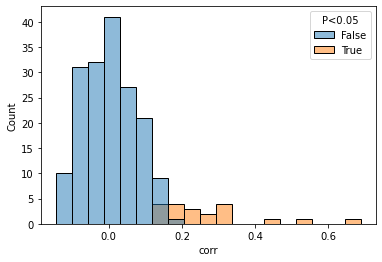

In [73]:
ax = sns.histplot(x = raw_aqueous_mantel_results_u["corr"], hue = raw_aqueous_mantel_results_u["P<0.05"])

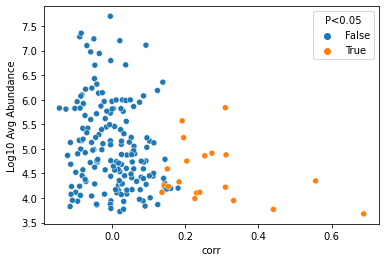

In [74]:
ax = sns.scatterplot(data=raw_aqueous_mantel_results_u,
                    x="corr",
                    y="Log10 Avg Abundance",
                    hue="P<0.05")

In [75]:
raw_aqueous_mantel_results_u[raw_aqueous_mantel_results_u["P<0.05"]].sort_values("corr", ascending=False)

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance
Compound,,,,,
Acetylagmatine_2.216,0.687763,0.0001,4731.414607,True,3.674991
C1287 - 5.388,0.556128,0.0001,22172.437338,True,4.345813
Lactiflorin_7.997,0.44078,0.0009,5865.543005,True,3.768308
L-Pyridosine_6.949,0.331932,0.0021,8817.897746,True,3.945365
C943 - 3.968,0.311261,0.0003,75293.593138,True,4.876758
Shikonofuran D_8.462,0.309641,0.0007,16539.438106,True,4.218521
Clitidine_5.347,0.309533,0.0012,687436.486897,True,5.837233
gamma-Glutamyl-alanine_1.2,0.272857,0.0026,81400.845379,True,4.910629
Dopamine_2.414,0.253271,0.0014,72141.413232,True,4.858185


In [76]:
raw_aqueous_mantel_results_u[raw_aqueous_mantel_results_u["P<0.05"]].sort_values("Avg Abundance")

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance
Compound,,,,,
Acetylagmatine_2.216,0.687763,0.0001,4731.414607,True,3.674991
Lactiflorin_7.997,0.44078,0.0009,5865.543005,True,3.768308
L-Pyridosine_6.949,0.331932,0.0021,8817.897746,True,3.945365
Ethyl-p-methoxycinnamate_8.596,0.226197,0.010699,9732.955728,True,3.988245
Pipecolic acid_2.82,0.230628,0.008599,12628.994611,True,4.101369
Menisporphine_1.669,0.239803,0.018298,13006.262416,True,4.114153
Dibenzothiophene_2.207,0.136271,0.049795,13012.075878,True,4.114347
Shikonofuran D_8.462,0.309641,0.0007,16539.438106,True,4.218521
Mandelonitrile_6.399,0.154139,0.030997,17136.260943,True,4.233916


### Lipid

In [77]:
raw_lipid_samples_index = raw_lipid_samples.index
raw_lipid_mantel_results_u = pd.DataFrame(index=raw_lipid_samples.columns,
                                            columns=["corr","p"])

for col in raw_lipid_samples.columns:
    metabo_dist_mat = make_euclidean_distance_matrix(raw_lipid_samples[col], 
                                                     ids=raw_lipid_samples_index)
    
    corr, p, n = distance.mantel(metabo_dist_mat, microbiome_u_uni, method="pearson", permutations=10000)
    
    raw_lipid_mantel_results_u.loc[col,"corr"] = corr
    raw_lipid_mantel_results_u.loc[col,"p"] = p

In [78]:
raw_lipid_mantel_results_u["Avg Abundance"] = raw_lipid_samples.sum(axis=0)/raw_lipid_samples.shape[0]
raw_lipid_mantel_results_u["P<0.05"] = raw_lipid_mantel_results_u["p"]<0.05
raw_lipid_mantel_results_u["Log10 Avg Abundance"] = raw_lipid_mantel_results_u["Avg Abundance"].apply(lambda x: np.log10(x+0.0001))

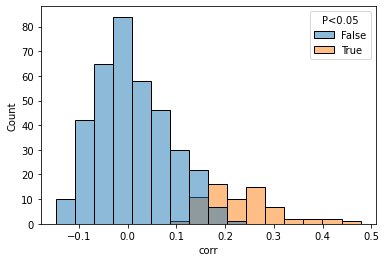

In [79]:
ax = sns.histplot(x = raw_lipid_mantel_results_u["corr"], hue = raw_lipid_mantel_results_u["P<0.05"])

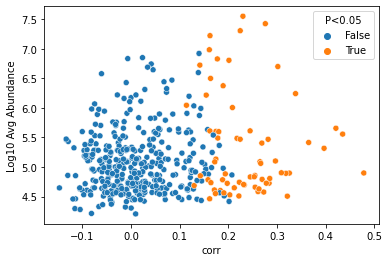

In [80]:
ax = sns.scatterplot(data=raw_lipid_mantel_results_u,
                    x="corr",
                    y="Log10 Avg Abundance",
                    hue="P<0.05")

In [146]:
raw_lipid_mantel_results_u[raw_lipid_mantel_results_u["P<0.05"]].sort_values("corr", ascending=False).head(30)

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance,BH reject,BH p
Compound,,,,,,,
C458 - 3.513,0.478011,0.0001,79087.839483,True,4.898110,True,0.021598
C846 - 4.744,0.434591,0.0011,360006.759793,True,5.556311,False,0.079192
"(22Z,24S)-Cerevisterol_4.476",0.420785,0.0001,451926.535655,True,5.655068,True,0.021598
"CL(22:5(7Z,10Z,13Z,16Z,19Z)/18:2(9Z,12Z)/22:5(7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z))_4.399",0.396481,0.0015,206948.652966,True,5.315863,False,0.080992
C1461 - 7.178,0.364886,0.0005,259461.314328,True,5.414073,False,0.053995
C1509 - 6.495,0.337923,0.0008,1742868.905517,True,6.241265,False,0.069113
"MGDG(20:5(5Z,8Z,11Z,14Z,17Z)/18:4(6Z,9Z,12Z,15Z))_4.412",0.325235,0.0017,78839.512345,True,4.896744,False,0.081592
C386 - 3.891,0.321089,0.0024,32037.518,True,4.505659,False,0.10367
"MGDG(20:5(5Z,8Z,11Z,14Z,17Z)/18:4(6Z,9Z,12Z,15Z))_4.32",0.318217,0.0028,78046.566621,True,4.892354,False,0.109953


One note from a quick google - Cerevisterol is a potent NF-kappa B inhibitor according to wikipedia

### Compounds detected

In [84]:
from statsmodels.stats.multitest import multipletests

In [85]:
res = multipletests(raw_aqueous_mantel_results_u["p"], method="fdr_bh")
raw_aqueous_mantel_results_u["BH reject"] = res[0]
raw_aqueous_mantel_results_u["BH p"] = res[1]

In [86]:
raw_aqueous_mantel_results_u[raw_aqueous_mantel_results_u["BH reject"]==True]

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance,BH reject,BH p
Compound,,,,,,,
Shikonofuran D_8.462,0.309641,0.0007,16539.438106,True,4.218521,True,0.033597
Clitidine_5.347,0.309533,0.0012,687436.486897,True,5.837233,True,0.038396
C943 - 3.968,0.311261,0.0003,75293.593138,True,4.876758,True,0.019198
Dopamine_2.414,0.253271,0.0014,72141.413232,True,4.858185,True,0.038396
Acetylagmatine_2.216,0.687763,0.0001,4731.414607,True,3.674991,True,0.009599
C1287 - 5.388,0.556128,0.0001,22172.437338,True,4.345813,True,0.009599
Lactiflorin_7.997,0.44078,0.0009,5865.543005,True,3.768308,True,0.034557


In [147]:
for comp in raw_aqueous_mantel_results_u[raw_aqueous_mantel_results_u["BH reject"]==True].index:
    print(comp)

Shikonofuran D_8.462
Clitidine_5.347
C943 - 3.968
Dopamine_2.414
Acetylagmatine_2.216
C1287 - 5.388
Lactiflorin_7.997


In [87]:
res = multipletests(raw_lipid_mantel_results_u["p"], method="fdr_bh")
raw_lipid_mantel_results_u["BH reject"] = res[0]
raw_lipid_mantel_results_u["BH p"] = res[1]

In [88]:
raw_lipid_mantel_results_u[raw_lipid_mantel_results_u["BH reject"]==True]

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance,BH reject,BH p
Compound,,,,,,,
C458 - 3.513,0.478011,0.0001,79087.839483,True,4.898110,True,0.021598
"(22Z,24S)-Cerevisterol_4.476",0.420785,0.0001,451926.535655,True,5.655068,True,0.021598


In [151]:
for comp in raw_lipid_mantel_results_u[raw_lipid_mantel_results_u["P<0.05"]].sort_values("corr", ascending=False).index:
    print(comp)

C458 - 3.513
C846 - 4.744
(22Z,24S)-Cerevisterol_4.476
CL(22:5(7Z,10Z,13Z,16Z,19Z)/18:2(9Z,12Z)/22:5(7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z))_4.399
C1461 - 7.178
C1509 - 6.495
MGDG(20:5(5Z,8Z,11Z,14Z,17Z)/18:4(6Z,9Z,12Z,15Z))_4.412
C386 - 3.891
MGDG(20:5(5Z,8Z,11Z,14Z,17Z)/18:4(6Z,9Z,12Z,15Z))_4.32
C1085 - 4.761
PC(16:0/22:4(7Z,10Z,13Z,16Z))_5.523
PI(20:4(8Z,11Z,14Z,17Z)/16:0)_3.679
Montecristin_4.032
Montecristin_4.206
PS(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/19:1(9Z))_5.293
C1094 - 5.887
PC(22:5(7Z,10Z,13Z,16Z,19Z)/14:0)_5.189
PG(P-20:0/0:0)_3.626
DG(22:4n6/0:0/20:4n3)_6.641
C864 - 4.495
C1286 - 4.713
3-Teracrylmelazolide A_1.042
C1657 - 4.663
Ixabepilone_0.889
C883 - 2.885
C1091 - 7.192
C1445 - 2.053
cholesteryl beta-D-glucoside_1.932
PA(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/22:2(13Z,16Z))_5.211
Teixidol_1.049
C1716 - 1.766
PC(22:4(7Z,10Z,13Z,16Z)/16:0)_6.391
PC(22:2(13Z,16Z)/14:1(9Z))_5.254
PS(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/19:1(9Z))_5.169
C239 - 6.896
C1500 - 7.093
C839 - 4.736
Ixabepilone_0.985
SLBPA(4

In [92]:
total_aqueous_compounds = raw_aqueous_samples.shape[1]
significant_aqueous_compounds = raw_aqueous_mantel_results_u["P<0.05"].sum()
corrected_sig_aq_c = raw_aqueous_mantel_results_u["BH reject"].sum()


print(f"{raw_aqueous_samples.shape[1]} green tea compounds were detected in the aqueous fraction of plasma")
print(f"{significant_aqueous_compounds} ({round(significant_aqueous_compounds/total_aqueous_compounds,3)*100}%)",
      "of these compounds were significantly associated with microbiome composition")
print(f"After applying a Benjamini-Hochberg correction, only ",
      f"{corrected_sig_aq_c} ({round(corrected_sig_aq_c/total_aqueous_compounds*100,1)}%) ",
      "were significantly associated with microbiome composition")


192 green tea compounds were detected in the aqueous fraction of plasma
20 (10.4%) of these compounds were significantly associated with microbiome composition
After applying a Benjamini-Hochberg correction, only  7 (3.6%)  were significantly associated with microbiome composition


In [94]:
total_lipid_compounds = raw_lipid_samples.shape[1]
significant_lipid_compounds = raw_lipid_mantel_results_u["P<0.05"].sum()
corrected_sig_lip_c = raw_lipid_mantel_results_u["BH reject"].sum()


print(f"{raw_lipid_samples.shape[1]} green tea compounds were detected in the aqueous fraction of plasma")
print(f"{significant_lipid_compounds} ({round(significant_lipid_compounds/total_lipid_compounds,3)*100}%)",
      "of these compounds were significantly associated with microbiome composition")
print(f"After applying a Benjamini-Hochberg correction, only ",
      f"{corrected_sig_lip_c} ({round(corrected_sig_lip_c/total_lipid_compounds*100,1)}%) ",
      "were significantly associated with microbiome composition")



432 green tea compounds were detected in the aqueous fraction of plasma
67 (15.5%) of these compounds were significantly associated with microbiome composition
After applying a Benjamini-Hochberg correction, only  2 (0.5%)  were significantly associated with microbiome composition


## Procrustes randomization test

In [96]:
#A procrustes randomization test! aka protest
def protest(a,b,n=999):
    """a: pd.DataFrame of Ordination coordinates for dataset a
     b: pd.DataFrame of Ordination coordinates for dataset b
     n: Integer, number of randomizations
     - - - - - - - - - - - - - - - - - - - - 
     returns:
     disparity, pval"""
    mtx1, mtx2, disparity = procrustes(a, b)
  
    #Randomization test time
    rows, cols = a.shape

    #disparities will be the list containing M^2 values for each test
    disparities = []
    for x in range(n):

      #start by randomly sampling 100% of the ordination coordinates
        a_rand = a.sample(frac=1,axis=0).reset_index(drop=True)
        b_rand = b.sample(frac=1,axis=0).reset_index(drop=True)

        #run the procrustes on the two randomly sampled coordinates
        mtx1_rand, mtx2_rand, disparity_rand = procrustes(a_rand,
                                                        b_rand)

        #add the result to disparities
        disparities.append(disparity_rand)

    #set pval = proportion of randomized samples where the random disparity is smaller than
    #our observed disparity
    pval = (sum([disparity > d for d in disparities])+1)/(n+1)

    return disparity, pval, disparities


In [159]:
def procrustes_plot(a,b, a_name,b_name, palette=None):
    mtx1, mtx2, disparity = procrustes(a, b)
    proplot = pd.concat([pd.DataFrame(mtx1), pd.DataFrame(mtx2)])
    proplot.columns = ["PCo1", "PCo2", "PCo3"]
    proplot["Dataset"] = [a_name]*a.shape[0] + [b_name]*b.shape[0]
    
    ax = sns.scatterplot(x="PCo1",y="PCo2",
                         style="Dataset",hue="Dataset",
                         data=proplot,
                         markers=["v","o"],
                         palette=palette,
                         s=150)

    for i in range(len(mtx1)):
        plt.plot([mtx1[i,0],mtx2[i,0]],
                 [mtx1[i,1],mtx2[i,1]],
                 c="black", linewidth=0.75)

In [99]:
microbiome_pcoa_u_uni = ordination.pcoa(microbiome_u_uni, number_of_dimensions=3)

/Users/johnsterrett/mambaforge/envs/qiime2-2021.11/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.009383724064282492 and the largest is 2.384134278128227.
  warn(


#### Microbiome-aqueous

In [160]:
disparity, p, disparities = protest(microbiome_pcoa_u_uni.samples, aqueous_pcoa_res.samples)
print(f'pval: {p} \ndisparity: {disparity}')

pval: 0.797 
disparity: 0.9608043121800911


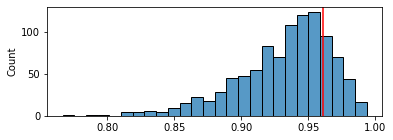

In [161]:
ax = sns.histplot(disparities)
ax.axvline(disparity, c="r")
plt.gcf().set_size_inches(6,2)

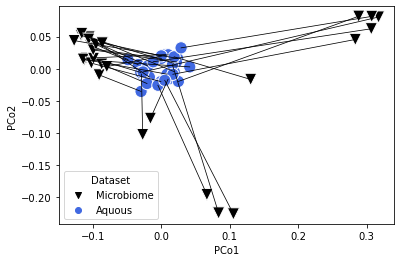

In [169]:
procrustes_plot(microbiome_pcoa_u_uni.samples, aqueous_pcoa_res.samples,
                "Microbiome", "Aquous",
               palette=["black","royalblue"])
plt.show()

#### Microbiome-lipid

In [139]:
disparity, p, disparities = protest(microbiome_pcoa_u_uni.samples, lipid_pcoa_res.samples)
print(f'pval: {p} \ndisparity: {disparity}')

pval: 0.011 
disparity: 0.8231211080554481


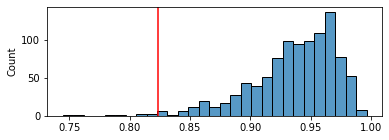

In [140]:
ax = sns.histplot(disparities)
ax.axvline(disparity, c="r")
plt.gcf().set_size_inches(6,2)
plt.show()

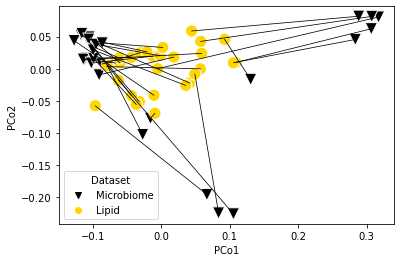

In [173]:
procrustes_plot(microbiome_pcoa_u_uni.samples, lipid_pcoa_res.samples,
                "Microbiome", "Lipid",
                palette=["black","gold"])
plt.show()

#### Lipid-aqueous

In [142]:
disparity, p, disparities = protest(lipid_pcoa_res.samples, aqueous_pcoa_res.samples)
print(f'pval: {p} \ndisparity: {disparity}')

pval: 0.06 
disparity: 0.8664413877395081


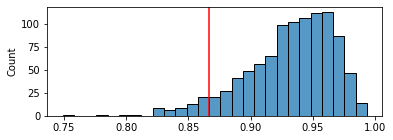

In [143]:
ax = sns.histplot(disparities)
ax.axvline(disparity, c="r")
plt.gcf().set_size_inches(6,2)
plt.show()

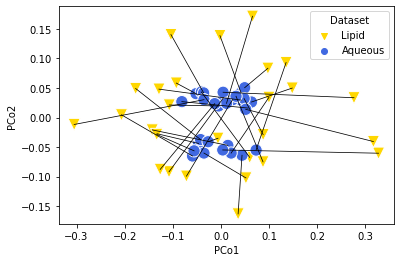

In [176]:
procrustes_plot(lipid_pcoa_res.samples, aqueous_pcoa_res.samples,
                "Lipid", "Aqueous",
               palette=["gold", "royalblue"])
plt.show()

In [117]:
micro_pro, lipid_pro, disparity = procrustes(microbiome_pcoa_u_uni.samples, lipid_pcoa_res.samples)
proplot = pd.concat([pd.DataFrame(micro_pro), pd.DataFrame(lipid_pro)])
proplot.columns = ["PCo1", "PCo2", "PCo3"]
proplot["Dataset"] = ["Microbiome"]*microbiome.shape[0] + ["Lipid"]*raw_lipid_samples.shape[0]


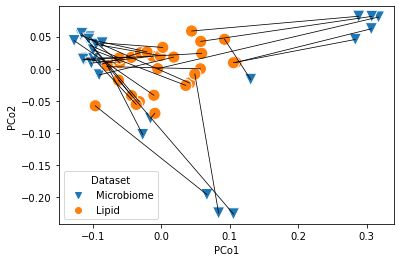

In [118]:
ax = sns.scatterplot(x="PCo1",y="PCo2",
                     style="Dataset",hue="Dataset",
                     data=proplot,
                     markers=["v","o"],
                     s=150)

for i in range(len(micro_pro)):
    plt.plot([micro_pro[i,0],lipid_pro[i,0]],
             [micro_pro[i,1],lipid_pro[i,1]],
             c="black", linewidth=0.75)

In [128]:
metabo_metadata

,#SampleID,Plate,Well,#,BarcodeSequence,LinkerPrimerSequence,BarcodeName,PID,Group,Study,DNA_Conc,Amplified_Conc,Extraction_Date,Extraction_Location,Extraction_By
MetaboSampleID,,,,,,,,,,,,,,,
18,GT.063_N,2,B07,48,TTAACAAGGCAA,GTGYCAGCMGCCGCGGTAA,515rcbc222,63,Red,Green Tea,15.3,62.55,10/13/21,BSC,MK
3,GT.063_R,1,E01,49,TGATGTGCTAAG,GTGYCAGCMGCCGCGGTAA,515rcbc48,63,Red,Green Tea,39.9,51.15,10/13/21,BSC,MK
17,GT.066_B,2,A09,54,CCAGGACAGGAA,GTGYCAGCMGCCGCGGTAA,515rcbc200,66,Red,Green Tea,18.6,67.90,10/13/21,BSC,MK
29,GT.066_N,1,F12,55,AACTCAATAGCG,GTGYCAGCMGCCGCGGTAA,515rcbc167,66,Red,Green Tea,32.9,41.80,10/13/21,BSC,MK
2,GT.074_N,2,C12,52,GATATACCAGTG,GTGYCAGCMGCCGCGGTAA,515rcbc227,74,Red,Green Tea,9.8,38.75,10/13/21,BSC,MK
5,GT.074_R,2,A10,53,GCGCGGCGTTGC,GTGYCAGCMGCCGCGGTAA,515rcbc201,74,Red,Green Tea,18.0,55.15,10/13/21,BSC,MK
6,GT.086_B,2,A11,51,GTCGCTTGCACA,GTGYCAGCMGCCGCGGTAA,515rcbc202,86,Red,Green Tea,17.6,61.80,10/13/21,BSC,MK
16,GT.086_N,2,B02,50,AATACAGACCTG,GTGYCAGCMGCCGCGGTAA,515rcbc205,86,Red,Green Tea,16.6,82.15,10/13/21,BSC,MK
24,GT.089_B,2,D07,57,AAGTCACACACA,GTGYCAGCMGCCGCGGTAA,515rcbc234,89,Red,Green Tea,8.0,53.85,10/13/21,BSC,MK
